<a href="https://colab.research.google.com/github/Luana-lrb/LIPAI_Python/blob/main/onboarding/src/semana_12/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementação FCN**

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_DIR = "/content/drive/MyDrive/dataset_displasia/images_original"
MASK_DIR = "/content/drive/MyDrive/dataset_displasia/gold_standart"

In [ ]:
class OralDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image, mask = self.transform(image, mask)

        mask = torch.squeeze(mask, dim=0)
        mask = (mask > 0).long()

        return image, mask


In [ ]:
def build_samples(img_root, mask_root):
    samples = []

    for cls in ["healthy", "severe"]:
        img_dir = os.path.join(img_root, cls)
        mask_dir = os.path.join(mask_root, cls)

        imgs = sorted(os.listdir(img_dir))
        masks = sorted(os.listdir(mask_dir))

        for img, mask in zip(imgs, masks):
            samples.append((
                os.path.join(img_dir, img),
                os.path.join(mask_dir, mask)
            ))

    return samples

In [ ]:
def split_data(samples, seed=42):

      if len(samples) == 0:
          raise ValueError("Samples vazio")

      imgs, masks = zip(*samples)

      # 70% treino+val e 30% teste
      img_tv, img_test, mask_tv, mask_test = train_test_split(
          imgs, masks,
          test_size= 0.3,
          random_state=seed,
          shuffle=True
      )

      # dentro dos 70% ( 80% treino e 20% val)
      img_train, img_val, mask_train, mask_val = train_test_split(
          img_tv, mask_tv,
          test_size=0.2,
          random_state=seed,
          shuffle=True
      )

      train = list(zip(img_train, mask_train))
      val   = list(zip(img_val, mask_val))
      test  = list(zip(img_test, mask_test))

      return train, val, test

### **Aumento de dados**

In [ ]:
class BasicTransform:
    def __init__(self):
        self.img_tf = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        self.mask_tf = transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])

    def __call__(self, image, mask):
        image = self.img_tf(image)
        mask = self.mask_tf(mask)
        return image, mask

In [ ]:
class AugmentedTransform:
    def __init__(self):
        self.img_resize = transforms.Resize((256, 256))
        self.mask_resize = transforms.Resize(
            (256, 256),
            interpolation=Image.NEAREST
        )
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, mask):
        image = self.img_resize(image)
        mask = self.mask_resize(mask)

        if torch.rand(1) > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        if torch.rand(1) > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)

        image = self.to_tensor(image)
        mask = self.to_tensor(mask)

        return image, mask

In [ ]:
basic_tf = BasicTransform()
aug_tf = AugmentedTransform()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def metrics(pred, target):
    pred = torch.argmax(pred, dim=1)

    tp = ((pred == 1) & (target == 1)).sum().float()
    fp = ((pred == 1) & (target == 0)).sum().float()
    fn = ((pred == 0) & (target == 1)).sum().float()
    tn = ((pred == 0) & (target == 0)).sum().float()

    acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)

    return acc.item(), dice.item(), iou.item()

Treinamento

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    accs, dices, ious = [], [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            out = model(imgs)["out"]

            acc, dice, iou = metrics(out, masks)
            accs.append(acc)
            dices.append(dice)
            ious.append(iou)

    return np.mean(accs), np.mean(dices), np.mean(ious)


In [ ]:
def train_validate_test( train_loader, val_loader, test_loader, epochs=10, lr=1e-4 ):
    model = fcn_resnet50(weights="DEFAULT")
    model.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)

    for name, param in model.backbone.named_parameters():
      if "layer4" in name:
          param.requires_grad = True
      else:
        param.requires_grad = False

    model = model.to(device)

    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 3.0]).to(device))

    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_dice = -1
    best_metrics_val = None
    best_epoch = 0

    for epoch in range(epochs):
        # ----- treino -----
        model.train()
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            out = model(imgs)["out"]
            loss = criterion(out, masks)
            loss.backward()
            optimizer.step()

        # ----- validação -----
        val_acc, val_dice, val_iou = evaluate(model, val_loader, device)

        print(f"Epoch {epoch+1}/{epochs}, Val ACC:  {val_acc:.4f}, Val DICE: {val_dice:.4f}, Val IoU:  {val_iou:.4f}\n")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            best_metrics_val = (val_acc, val_dice, val_iou)
            best_epoch = epoch + 1

    print(f"Melhor época: {best_epoch} (Val DICE = {best_val_dice:.4f})")

    # ----- teste -----
    test_acc, test_dice, test_iou = evaluate(model, test_loader, device)

    return {
        "val":  best_metrics_val,
        "test": (test_acc, test_dice, test_iou)
    }


In [ ]:
samples = build_samples(IMG_DIR, MASK_DIR)

train_samples, val_samples, test_samples = split_data(samples)

### Sem Augmentation

In [ ]:
train_ds = OralDataset(train_samples, transform=BasicTransform())
val_ds   = OralDataset(val_samples, transform=BasicTransform())
test_ds  = OralDataset(test_samples, transform=BasicTransform())

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=4, shuffle=False)

results_no_aug = train_validate_test(train_loader, val_loader, test_loader)

Epoch 1/10, Val ACC:  0.5932, Val DICE: 0.5727, Val IoU:  0.4026

Epoch 2/10, Val ACC:  0.7666, Val DICE: 0.6831, Val IoU:  0.5195

Epoch 3/10, Val ACC:  0.7843, Val DICE: 0.6964, Val IoU:  0.5352

Epoch 4/10, Val ACC:  0.7980, Val DICE: 0.6944, Val IoU:  0.5329

Epoch 5/10, Val ACC:  0.8005, Val DICE: 0.7036, Val IoU:  0.5440

Epoch 6/10, Val ACC:  0.7954, Val DICE: 0.6973, Val IoU:  0.5367

Epoch 7/10, Val ACC:  0.8042, Val DICE: 0.7088, Val IoU:  0.5501

Epoch 8/10, Val ACC:  0.8207, Val DICE: 0.6931, Val IoU:  0.5321

Epoch 9/10, Val ACC:  0.7844, Val DICE: 0.7003, Val IoU:  0.5398

Epoch 10/10, Val ACC:  0.8128, Val DICE: 0.7068, Val IoU:  0.5478

Melhor época: 7 (Val DICE = 0.7088)


### Com Augmentation

In [ ]:
train_ds = OralDataset(train_samples, transform=AugmentedTransform())
val_ds   = OralDataset(val_samples, transform=BasicTransform())
test_ds  = OralDataset(test_samples, transform=BasicTransform())

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=4, shuffle=False)


results_aug = train_validate_test(train_loader, val_loader, test_loader)

Epoch 1/10, Val ACC:  0.6403, Val DICE: 0.5890, Val IoU:  0.4188

Epoch 2/10, Val ACC:  0.7514, Val DICE: 0.6747, Val IoU:  0.5103

Epoch 3/10, Val ACC:  0.7930, Val DICE: 0.7010, Val IoU:  0.5407

Epoch 4/10, Val ACC:  0.8102, Val DICE: 0.7144, Val IoU:  0.5565

Epoch 5/10, Val ACC:  0.7676, Val DICE: 0.6937, Val IoU:  0.5323

Epoch 6/10, Val ACC:  0.7927, Val DICE: 0.7126, Val IoU:  0.5545

Epoch 7/10, Val ACC:  0.8034, Val DICE: 0.7186, Val IoU:  0.5616

Epoch 8/10, Val ACC:  0.8123, Val DICE: 0.7154, Val IoU:  0.5578

Epoch 9/10, Val ACC:  0.8017, Val DICE: 0.7167, Val IoU:  0.5594

Epoch 10/10, Val ACC:  0.8100, Val DICE: 0.7201, Val IoU:  0.5638

Melhor época: 10 (Val DICE = 0.7201)


### Comparação

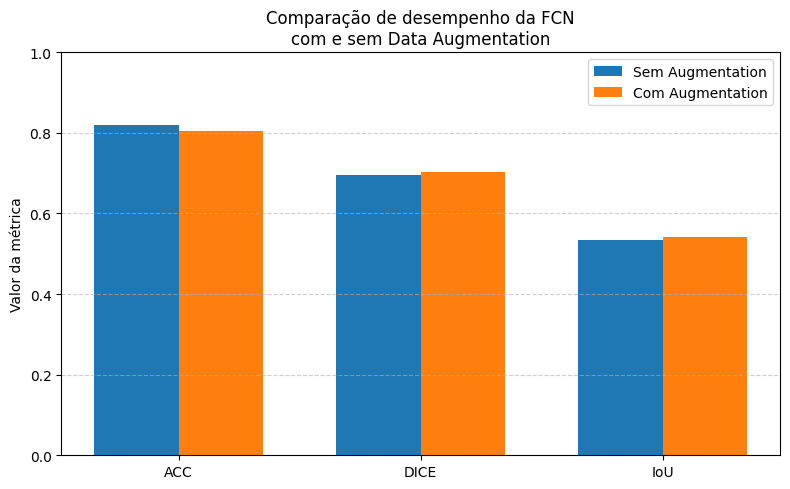

In [ ]:
metrics_names = ["ACC", "DICE", "IoU"]

no_aug = results_no_aug["test"]
aug    = results_aug["test"]

x = np.arange(len(metrics_names))  # [0, 1, 2]
width = 0.35

plt.figure(figsize=(8, 5))

plt.bar(x - width/2, no_aug, width, label="Sem Augmentation")
plt.bar(x + width/2, aug,    width, label="Com Augmentation")

plt.xticks(x, metrics_names)
plt.ylabel("Valor da métrica")
plt.ylim(0, 1)
plt.title("Comparação de desempenho da FCN\ncom e sem Data Augmentation")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()